# An automated workflow to reveal potential fraudulent activity in music streaming services

## Preliminary considerations and Outline of the approach 

The goal is to identify potential user profiles or behaviours likely belonging to bots   
The approach is unsupervised in the sense that there are no labels assigned in any of the datasets pointing out what is a fraudulent user account or stream and what are real human users.  
Another important consideration is that we don't know how sophisticated the netbots could be. One bot could be responsible of multiple user accounts with randomized personal data (gender/age), country of origin (set with VPN), controlling maximum number of stream counts per track, etc... In general terms, the more elaborate the botnet, the harder it will be to discern the fraudulent activity from real human users activity.  

In any case, one reasonable approach could consist on looking for potential 'red flags'/giveaways taking a closer look in particular to users that stream tracks more frequently in proportion to what could be defined as 'average' background population. And then it could be insightful to combine those relative frequencies and create a scoring method to measure the likelihood of an account being a bot.

In a following step it could be possible to using the scoring method to select a subset of users that are likely bots and a subset of users likely humans. Once the labels are set, it can be useful to build some classifiers SVD, DecisionTrees, ANN, ... and apply on new datasets to highlight potential 'fraudulent' user profiles (For example users from a particular country using a certain OS, on PC, etc...)

The whole data collection, processing and generation of results is orchestrated using Apache **Airflow**.  
The workflow is contained in **pipeline.py** :   
1st the data is downloaded and unzipped using functions in **fetch.py**   
Next the data from 'streams', 'users' and 'tracks' is read and processed with functions in **preprocess.py**  
Finally the results, predicting potential fraudulent user activity is done with **classifier.py**  


This notebook includes only some of the most important functions and steps in the workflow, please refer to the files for details.

### Fetch data from Bucket in Google Cloud Storage 

In [1]:
#FETCH Data from Google Cloud

#NOTE: Don't run this in the notebook. This is in fetch.py. It's shown here only for Illustration purpose:

import os
import subprocess

bucket_id = 'ru-0c488479-2436-40a1-9e13-c9831c8a938d'
bucket_id_url = 'gs://ru-0c488479-2436-40a1-9e13-c9831c8a938d'
current_folder = os.path.dirname(os.path.abspath(os.getcwd()))

def fetch_data():

    cp_cmd = "gsutil cp -r  %s %s"%(bucket_id_url, current_folder)
    subprocess.Popen(cp_cmd.split()).communicate()


### Data processing and analysis

In [1]:
import os
import numpy as np
import pandas as pd
import ast
import collections
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

#### Read the data from 'streams', 'users' and 'tracks'

In [2]:
def read_data(filename):
    '''
    reads the contents of streams, tracks and users into a list of dictionaries
    and returns a pandas dataframe
    '''

    lod = [] #list of dictionaries

    with open(filename) as f:
        for line in f:
            lod.append(ast.literal_eval(line))

    return pd.DataFrame(lod)

In [3]:
tracks = read_data('tracks')
users = read_data('users')
streams = read_data('streams')

#add the 'track' and 'user' information to the 'streams' dataframe for comodity
streams = pd.merge(streams, users, on='user_id')
streams = pd.merge(streams, tracks, on='track_id')

### Find some parameters based on Normalized Frequency of Streams :

This was motivated by the fact that the users in top of stream_counts (streams sorted by number of times a track is played by a user)   
Eg. users[users.user_id == '8ec3584b7ef681f6b817c6b2a5b54153011d7efa']   
come mainly from a couple of countries. Interesting   

Now sorting the user accounts by number of streams doesn't really prove anything, right?
But maybe some insights can be acquired   

Also, there might be real human users from one country that are just very heavy users. Yes  
But one could **normalize** the frequency in the top n to the frequency in a random background of n streams  

In addition, in the same way this is observed for a country, it could also be the case for users of a certain OS, with a particular type of account (free, premium), etc...

In this way it could be possible to find some pattern or profile of users that stream certain tracks proportionally more than an 'average' background population.


In [10]:

def nfsc(streams, group_by, top_n):

    '''
    Normalized Frequency of Stream Counts: nfsc
    group_by is one of ['country', 'os', 'access', 'device_type', 'gender']
    Get frequencies of streams per ['country', 'os', 'access', 'device_type', 'gender'] in the top_n stream counts 
    and normalize it to the frequency in the background (random n) streams
    '''
    #stream_counts = streams.groupby(['user_id', 'track_id']).size().reset_index(name='counts')
    #stream_counts.sort_values(by='counts', ascending=False)

    #Get the top n users in stream_counts:
    top_streams_users = stream_counts.sort_values(by='counts', ascending=False).head(top_n).user_id
    #And get the country/os/access of those users
    top_streams_users_grouped = [streams[streams.user_id == u][group_by].values[0] for u in top_streams_users]

    #rand_streams_users_grouped = [users[users.user_id == u].country.values[0] for u in streams.sample(top_n).user_id]
    rand_streams_users_grouped = [streams[streams.user_id == u][group_by].values[0] for u in streams.sample(top_n).user_id]

    #Normalize frequency in top1000 to freq in rand1000
    freq_top = collections.Counter(top_streams_users_grouped)
    freq_rand = collections.Counter(rand_streams_users_grouped)

    nfsc = {}

    for i in list(set(streams[group_by])):
        f_top   = freq_top[i]  / float(top_n)
        f_rand  = freq_rand[i] / float(top_n)
        try:
            nfsc[i] = f_top / f_rand
        except ZeroDivisionError:
            nfsc[i] = 1.0

    return nfsc


### Illustrate this with an example
Here we can find and plot the country of origin for users responsible the Top 100 streams (a track played by a user) 
and then compare it to the country of origin for users in a random sample of 100 streams 

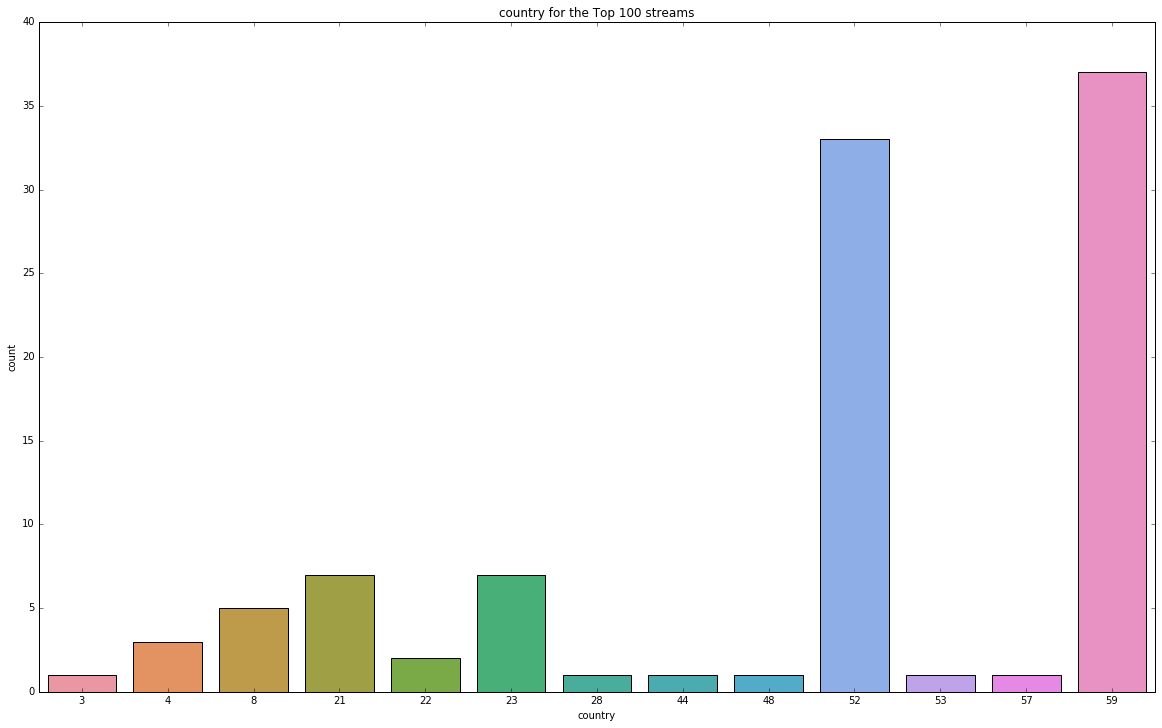

In [11]:
#count the number of times tracks are played by users:
stream_counts = streams.groupby(['user_id', 'track_id']).size().reset_index(name='counts')

group_by = 'country'
top_n = 100

#Find the users responsible for the top 100 streams (top meaning the higher counts of a track played by a user)
top_streams_users = stream_counts.sort_values(by='counts', ascending=False).head(100).user_id
top_streams_users_grouped = [streams[streams.user_id == u][group_by].values[0] for u in top_streams_users]

plt.figure(figsize=(20,12))
ax = sb.countplot(top_streams_users_grouped)
plt.xlabel(group_by)
plt.title('%s for the Top %s streams'%(group_by, top_n))
plt.show()

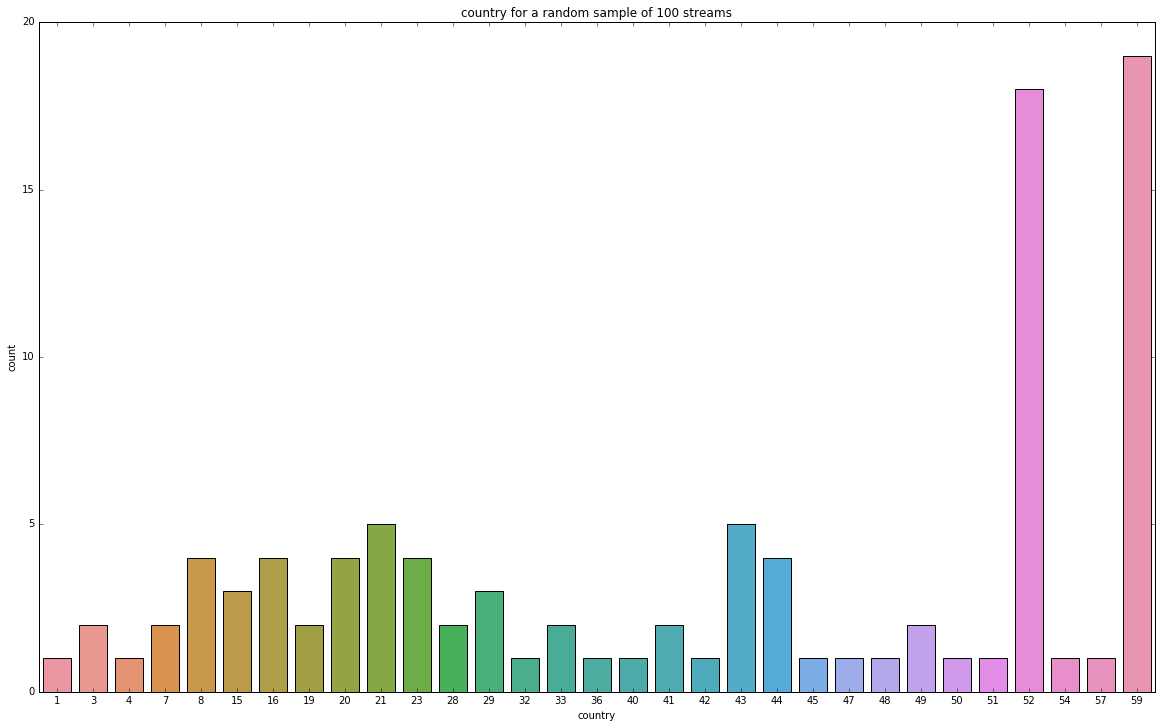

In [12]:
rand_streams_users_grouped = [streams[streams.user_id == u][group_by].values[0] for u in streams.sample(top_n).user_id]

plt.figure(figsize=(20,12))

ax = sb.countplot(rand_streams_users_grouped)
plt.xlabel(group_by)
plt.title('%s for a random sample of %s streams'%(group_by,top_n))
plt.show()


In this case the frequency of 'country' is first estimated for the users in the top 100 streams:  
Ex. Country #4 has a frequency of 4 / 100 in the top 100 streams  
Whereas the frequency in the background random sample of 100 streams its frequency is 2 / 100.  

The Normalized Stream Frequency for this country will be 2

In general  
if nfsc > 1 :  the group(e.g. country) is 'over-represented' in the top100 streams compared to the background rand100  
if nfsc == 1:  equal frequency in the top100 and rand100  
if nfsc < 1 :  the frequency of the country in the top100 streams is more or less random  


### Add Normalized Frequency of Streams data to Streams  

The nfsc data can be acquired not just for 'country' but also for   
'os' (are the users responsible for the top100 streams using mostly one type of OS? )   
'access' ('premium' or 'free'), 'device_type' ('desktop', 'phone'...) , 'gender', etc..  

Then a combined nfsc score (average of all of the above) is added to the streams dataframe.
It represents a pattern of users that stream tracks more frequently than a random sample of users. 
Again, this is all based on the assumption that fraudulent activity will be observed as a higher frequency of streams than what is considered average for a user profile.   

One limitation in this approach is that fraudulent streams with very few count of streams won't be detected. But the impact of those cases would be smaller in any case.


In [ ]:
def add_nfsc_to_streams(processes=0):

    #this takes quite long time. TO DO: Parallelize (see class MyPool below)
    #if processes > 0: pool = MyPool(processes) 

    for g in ['country', 'os', 'access', 'device_type', 'gender']:
        '''
        TO DO: Parallelize
        if processes > 0:
            pool.applyAsync(nfsc, [streams, g, 100])
            pool.checkPool()
        '''
        nfsc100 = nfsc(streams, group_by=g, top_n=100)
        nfsc500 = nfsc(streams, group_by=g, top_n=500)
        streams['nfsc100_%s'%g] = [nfsc100[c] for c in streams[g]]
        streams['nfsc500_%s'%g] = [nfsc500[c] for c in streams[g]]

    #add a combined nfsc_score
    #this score reflects a profile of users that stream tracks more frequently than 'average'
    cols = [c for c in streams.columns if 'nfsc' in c]
    streams['nfsc_score'] = streams[cols].mean(axis=1)
    return streams.sort_values(by='nfsc_score', ascending=False)

## Show potential fraudulent streams 

\* according to the combined nfsc score that represents certain user profiles (combination of OS, country, device, access and gender) among the top streamers that play tracks more frequently than a random subsample of the same size in the streams data   

Note,the nfsc data is read from a previously saved dataframe so all the nfsc estimations don't have to be run in this notebook

In [4]:
from IPython.display import display, HTML

streams_nfsc = pd.read_csv('streams_nfsc.csv', usecols=range(1,11), nrows=1000)

#Get the streams index for the top 100 nfsc scores
streams_idxs = streams_nfsc.sort_values(by='nfsc_score', ascending=False).index[0:100]
HTML(streams.iloc[streams_idxs].to_html())
#HTML(streams_nfsc.to_html())

## Classify / Predict streams using the Normalized Frequency of Streams data 

Using the stream data sorted by the combined nfsc score one could label the top (ex top 100) as potential fraudulent streams and the rest as real human users .  

Since the data is categorical some conversions to numerical data would be required to generate a training dataset for a classifier

In [5]:
def get_train_data(nfsc_sorted_streams):

	# In the streams df sorted by the combined nfsc_score, set label '1' to the first 100 and '0' to the rest
	streams['label'] =  [1]*100 + [0]*(len(streams)-100)

	#build a new df (train dataset) based on the considered features: country os access device_type gender
	dfX = streams[['country', 'os', 'access', 'device_type', 'gender', 'label']]

	#convert all categorical values to numbers and scale them to be between 0 and 1 for instance
	for g in ['os', 'access', 'device_type', 'gender']:
		d = dict(zip(set(dfX[g]),range(len(set(dfX[g])))))
		#set a number for each categorical value. (eg: 'iOS': 0, 'Android': 1, etc...)
		dfX[g] = [d[c] for c in dfX[g]] 

	#and scale those numbers to be between 0 and 1
	cols = ['country', 'os', 'access', 'device_type', 'gender']
	dfX[cols] = (dfX[cols] - dfX[cols].min()) / (dfX[cols].max() - dfX[cols].min())

	#dfX.to_csv('dfX.csv')
	#return dfX 


## Note: This part has not been thouroughly tested and was under development as of 06/03/2018   
### Modeling using different ML algorithms from sklearn    
Try different ML algorithms. From Sklearn:  

**Decision Trees (DTs)** are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

**Gradient Tree Boosting or Gradient Boosted Regression Trees (GBRT)** is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology.

**Random forests** : Each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. In addition, when splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset of the features

**Support Vector Machine C-Support Vector Classification**. The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to dataset with more than a couple of 10000 samples. The multiclass support is handled according to a one-vs-one scheme.

**Neural network MLPClassifier, MLP** trains on two arrays: array X of size (n_samples, n_features), which holds the training samples represented as floating point feature vectors; and array y of size (n_samples,), which holds the target values (class labels) for the training samples


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


mydata_train = pd.read_csv('dfX.csv')

features = ['country', 'os', 'access', 'device_type', 'gender']


#create randomized test data_set
r = 10**6
mydata_test = pd.DataFrame(index=range(r), columns=features)
mydata_test['os'] = list(mydata.os.sample(r))
mydata_test['access'] = list(mydata.access.sample(r))
mydata_test['gender'] = list(mydata.gender.sample(r))
mydata_test['country'] = list(mydata.country.sample(r))
mydata_test['device_type'] = list(mydata.device_type.sample(r))



#Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(mydata_train.ix[:,features]) 
X_train = scaler.transform(mydata_train.ix[:,features])
X_test = scaler.transform(mydata_test.ix[:,features])


y_train = list(mydata_train['label'].values)
y_test = list(mydata_test['label'].values)



#Train support vector machine model
svm = SVC(kernel='linear') #linear kernel seems to perform better than default 'rbf'
svm.fit(X, y)
print("\nSupport Vector Machine")
print("Accuracy on training set: {:.3f}".format(svm.score(X, y)))
#Prediction using SVM classifier
svm.predict(test_df)
#Re-write test data set including the assigned class
test_df['label'] = svm.predict(test_df)
test_df.to_csv('test_data_svm_classes.csv')
#Drop the label column to continue with the other classfiers
test_df = test_df.drop('label', 1)


#Train decision tree model
tree = DecisionTreeClassifier(random_state=0).fit(X, y)
print("\nDecision Tree")
print("Accuracy on training set: {:.3f}".format(tree.score(X, y)))
#Prediction using Decission Tree
tree.predict(test_df)
#Re-write test data set including the assigned class
test_df['label'] = tree.predict(test_df)
test_df.to_csv('test_data_tree_classes.csv')
test_df = test_df.drop('label', 1)


#Train Naive Bayes classifier
nb = GaussianNB()
nb.fit(X,y)
print("\nNaive Bayes")
print("Accuracy on training set: {:.3f}".format(nb.score(X, y)))
#Prediction using NB classifier
nb.predict(test_df)
#Re-write test data set including the assigned class
test_df['label'] = tree.predict(test_df)
test_df.to_csv('test_data_nb_classes.csv')
test_df = test_df.drop('label', 1)


#Train random forest model
forest = RandomForestClassifier(n_estimators=5, random_state=0).fit(X, y)
print("\nRandom Forests")
print("Accuracy on training set: {:.3f}".format(forest.score(X, y)))
#Prediction using Random Forest Classifier
forest.predict(test_df)
#Re-write test data set including the assigned class
test_df['label'] = forest.predict(test_df)
test_df.to_csv('test_data_forest_classes.csv')
test_df = test_df.drop('label', 1)


#Train gradient boosting model
gbrt = GradientBoostingClassifier(random_state=0).fit(X, y)
print("\nGradient Boosting")
print("Accuracy on training set: {:.3f}".format(gbrt.score(X, y)))
#Prediction using Gradient Boosting
gbrt.predict(test_df)
#Re-write test data set including the assigned class
test_df['label'] = gbrt.predict(test_df)
test_df.to_csv('test_data_nb_classes.csv')
test_df = test_df.drop('label', 1)





## An extension of the previous Normalized Streams Frequencies (nfsc) concept is the more robust statistical approach described below:
### 'Over-representation' or 'Enrichment' of one artist/band in the streams by a group of users

Provides a way to classify artists as potentially responsible for fraud (bots loop-streaming)  

Based on the following observation.   

Sort the stream counts (number of times a track is played by one user) : stream_counts.head(1)  

Track '25b1e75619a00b47119dbdd88bf4a37b854eedba' is present 2339 times in streams:  
len(streams[streams.track_id == '25b1e75619a00b47119dbdd88bf4a37b854eedba'])  
out of those 2339 times,  
user bbc91687167393872dcb557f6413e4acfed3ba77 has streamed it 2333 times.  


2333 of those times were streamed by just one user. In total only 3 users have streamed it  
set(streams[streams.track_id == '25b1e75619a00b47119dbdd88bf4a37b854eedba'].user_id)   

All 3 of them are from country 59  


This type of analysis links users with artists (or tracks/albums).   
The goal is to see whether an artist is over-represented in the streams  
by one particular user (or group of users) compared to the background (times the artist is played by all other users)  

for every user (or group of users) find:  

**N**: Total number of streams  
**k**: Number of streams by one particular user  
**m**: Number of streams of one particular artist(or album)  
**x**: Number of streams of the one particular artist (or album) by the one particular user  

![title](fishers.png)

The hypergeometric test (Fisher's exact test) provides the probability that   
in 'k' random observations from 'N' there will be 'x' observations matching the test (streams by artist)  
This probability is a p-value, it can be intepreted this way:  
Having a very low p-value means the the group's streams are 'enriched' in that particular artist,   
or in other words, the artist is 'over-represented' in that group considering the background (total streams by all users) 


**IMPORTANT NOTE!**:
What about users with very 'niche' taste: Only them (and nobody else) play ONLY very few artists (AND lots of times)
Right. These user accounts will get low p-values (which are ideally intended to represent bots). 
On the positive side:  
- This behaviour shouldn't be too common among real human users (Arguable)  
- This could be alleviated by introducing thresholds:  
	In the minimum stream count  
	In the minimum number of countries of origin  
- Repeating the enrichment for different groups of users (based on OS, Country, Access) could give a COMBINATION score that could be more robust  

Why would users from a certain country listen more to one artist? -> This has a plausible explanation. E.g. A group of South Korean users will have very low p-values for a K-pop-star
Why would users of a certain OS listen more to one artist? -> This is more strange, but it could happen
Why would users with a certain type of account ('free' or 'premium') would listen more to one artist? Same, it could happen

Combining all these it might be possible to find a pattern. Interesting!


In [ ]:

from scipy import stats
import statsmodels.sandbox.stats.multicomp as mc



def enrich(group_by, g, k, N, tests, tests_desc, xmin=10, top_N=1000):

    '''
    group_by: the column on which the grouping of k is based ('os', 'country', 'access' )
    g: the group in particular ('Android', 'iOS', etc..)
    tests_desc: what is tested (artist, track, album). Has to be an existing column in streams (the extended streams w all columns)
    uses scipy.stats hypergeometric test to extract probabilities (p-values) of track/album enrichment for a user/group of users
    k: column by which users are grouped (os, country, access,...)
    tests: what is tested for enrichment: artists, album, track...
    xmin: minimum number of times the 'artist' has to be present in the streams by the user
    top_N: add only top N results (lowest p-values) to output dataframe
    '''

    enrichment = pd.DataFrame(columns=["g", tests_desc, "x", "k", "m", "N", "p-val"])
    for i in range(len(tests)):
        x = len(streams[(streams[group_by] == g) & (streams[tests_desc] == tests[i])])
        if x > xmin: 
            m = len(streams[streams[tests_desc] == tests[i]])
            p = stats.hypergeom.sf(x, N, k, m)
            enrichment.loc[i] = [g, tests[i], x, k, m, N, p]
            print "%s\t%s\tx:%s k:%s m:%s N:%s p:%s"%(g,tests[i], x,k,m,N,p)
    #Multiple hypothesis correction, transform p-values to adjusted p-values:
    if len(tests) > 100:
        reject, adj_pvalues, corrected_a_sidak, corrected_a_bonf =  mc.multipletests(enrichment["p-val"], method='fdr_bh')
        enrichment["adj_pval(BH)"] = adj_pvalues
        enrichment = enrichment.sort_values(by='adj_pval(BH)').head(top_N)

    return enrichment


In [ ]:
def combine():

    '''
    concatenates (along rows) all dfs from the enrichment from each group.
    Ex: concatenates iOS, Android, Mac, Linux... to a long Df
    Three resulting long dfs: OS, Access, Country.
    Combines the p-values
    '''

    df_group_by_List = []
    for group_by in ['os', 'access', 'country']:
        dfgList = []
        for f in os.listdir('enrichment/%s/'%group_by):
            dfg = pd.read_csv('enrichment/%s/%s'%(group_by, f), usecols=range(9))
            dfg.rename(columns = {'Unnamed: 0':'streams_ix'}, inplace=True)
            dfg = dfg[dfg['adj_pval(BH)']<0.1][['streams_ix', 'album_artist', 'g', 'adj_pval(BH)']]
            dfgList.append(dfg)
        dfg = pd.concat(dfgList)
        df_group_by_List.append(dfg)

    #merge_cols = ['album_artist', 'g', 'adj_pval(BH)']
    dfX = reduce(lambda x, y: pd.merge(x, y, on = 'album_artist'), df_group_by_List)
    dfX = dfX.rename(columns={'g': 'country', 'adj_pval(BH)': 'p_country', 'g_x': 'os', \
                              'adj_pval(BH)_x': 'p_os', 'g_y': 'access', 'adj_pval(BH)_y': 'p_access'})

    dfX['p_avg'] = dfX[['p_os', 'p_access', 'p_country']].mean(axis=1)
    dfX = dfX.sort_values(by='p_avg')

    dfX.to_csv("dfX_enrichment.csv")
    return dfX


## Show potential fraudulent streams according to the 'enrichment' approach

All the enrichment results are written to tables under enrichment/
read dfX_enrichment.csv that contains the combined p-values that represent user account profiles with a combination of good p-values for 'device', 'access' and 'os'

In [7]:
from IPython.display import display, HTML

e = pd.read_csv('dfX_enrichment.csv', usecols=range(1,12))
e = e[e.p_avg < 0.01]

#Get the streams index for the top 100 nfsc scores
HTML(streams.iloc[list(e.streams_ix)].to_html())
#HTML(streams_nfsc.to_html())